### Example script for training MPNN-POM model

In [18]:
import deepchem as dc
from openpom.feat.graph_featurizer import GraphFeaturizer, GraphConvConstants
from openpom.utils.data_utils import get_class_imbalance_ratio
from openpom.models.mpnn_pom import MPNNPOMModel
from datetime import datetime


import numpy as np
import matplotlib.pyplot as plt

In [2]:
TASKS = [
'alcoholic', 'aldehydic', 'alliaceous', 'almond', 'amber', 'animal',
'anisic', 'apple', 'apricot', 'aromatic', 'balsamic', 'banana', 'beefy',
'bergamot', 'berry', 'bitter', 'black currant', 'brandy', 'burnt',
'buttery', 'cabbage', 'camphoreous', 'caramellic', 'cedar', 'celery',
'chamomile', 'cheesy', 'cherry', 'chocolate', 'cinnamon', 'citrus', 'clean',
'clove', 'cocoa', 'coconut', 'coffee', 'cognac', 'cooked', 'cooling',
'cortex', 'coumarinic', 'creamy', 'cucumber', 'dairy', 'dry', 'earthy',
'ethereal', 'fatty', 'fermented', 'fishy', 'floral', 'fresh', 'fruit skin',
'fruity', 'garlic', 'gassy', 'geranium', 'grape', 'grapefruit', 'grassy',
'green', 'hawthorn', 'hay', 'hazelnut', 'herbal', 'honey', 'hyacinth',
'jasmin', 'juicy', 'ketonic', 'lactonic', 'lavender', 'leafy', 'leathery',
'lemon', 'lily', 'malty', 'meaty', 'medicinal', 'melon', 'metallic',
'milky', 'mint', 'muguet', 'mushroom', 'musk', 'musty', 'natural', 'nutty',
'odorless', 'oily', 'onion', 'orange', 'orangeflower', 'orris', 'ozone',
'peach', 'pear', 'phenolic', 'pine', 'pineapple', 'plum', 'popcorn',
'potato', 'powdery', 'pungent', 'radish', 'raspberry', 'ripe', 'roasted',
'rose', 'rummy', 'sandalwood', 'savory', 'sharp', 'smoky', 'soapy',
'solvent', 'sour', 'spicy', 'strawberry', 'sulfurous', 'sweaty', 'sweet',
'tea', 'terpenic', 'tobacco', 'tomato', 'tropical', 'vanilla', 'vegetable',
'vetiver', 'violet', 'warm', 'waxy', 'weedy', 'winey', 'woody'
]
print("No of tasks: ", len(TASKS))

No of tasks:  138


In [3]:
# download curated dataset
!wget https://raw.githubusercontent.com/ARY2260/openpom/main/openpom/data/curated_datasets/curated_GS_LF_merged_4983.csv

# The curated dataset can also found at `openpom/data/curated_datasets/curated_GS_LF_merged_4983.csv` in the repo.

input_file = 'curated_GS_LF_merged_4983.csv' # or new downloaded file path

--2024-07-03 12:42:44--  https://raw.githubusercontent.com/ARY2260/openpom/main/openpom/data/curated_datasets/curated_GS_LF_merged_4983.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647971 (1.6M) [text/plain]
Saving to: ‘curated_GS_LF_merged_4983.csv.4’

curated_GS_LF_merge 100%[===================>]   1.57M  --.-KB/s    in 0.05s   

2024-07-03 12:42:44 (28.8 MB/s) - ‘curated_GS_LF_merged_4983.csv.4’ saved [1647971/1647971]



In [4]:
# get dataset

featurizer = GraphFeaturizer()
smiles_field = 'nonStereoSMILES'
loader = dc.data.CSVLoader(tasks=TASKS,
                   feature_field=smiles_field,
                   featurizer=featurizer)
dataset = loader.create_dataset(inputs=[input_file])
n_tasks = len(dataset.tasks)

In [5]:
len(dataset)

4983

In [6]:
# get train valid test splits

randomstratifiedsplitter = dc.splits.RandomStratifiedSplitter()
train_dataset, test_dataset, valid_dataset = randomstratifiedsplitter.train_valid_test_split(dataset, frac_train = 0.8, frac_valid = 0.1, frac_test = 0.1, seed = 1)

In [7]:
print("train_dataset: ", len(train_dataset))
print("valid_dataset: ", len(valid_dataset))
print("test_dataset: ", len(test_dataset))


train_dataset:  3999
valid_dataset:  498
test_dataset:  486


In [8]:
train_ratios = get_class_imbalance_ratio(train_dataset)
assert len(train_ratios) == n_tasks

In [9]:
learning_rate = dc.models.optimizers.ExponentialDecay(initial_rate=0.001, decay_rate=0.5, decay_steps=32*15, staircase=True)
#learning_rate = 0.001

In [10]:
# initialize model

model = MPNNPOMModel(n_tasks = n_tasks,
                            batch_size=128,
                            learning_rate=learning_rate,
                            class_imbalance_ratio = train_ratios,
                            loss_aggr_type = 'sum',
                            node_out_feats = 100,
                            edge_hidden_feats = 75,
                            edge_out_feats = 100,
                            num_step_message_passing = 5,
                            mpnn_residual = True,
                            message_aggregator_type = 'sum',
                            mode = 'classification',
                            number_atom_features = GraphConvConstants.ATOM_FDIM,
                            number_bond_features = GraphConvConstants.BOND_FDIM,
                            n_classes = 1,
                            readout_type = 'set2set',
                            num_step_set2set = 3,
                            num_layer_set2set = 2,
                            ffn_hidden_list= [392, 392],
                            ffn_embeddings = 256,
                            ffn_activation = 'relu',
                            ffn_dropout_p = 0.12,
                            ffn_dropout_at_input_no_act = False,
                            weight_decay = 1e-5,
                            self_loop = False,
                            optimizer_name = 'adam',
                            log_frequency = 32,
                            model_dir = './examples/experiments',
                            device_name='cuda')

In [11]:
model.model.forward

<bound method MPNNPOM.forward of MPNNPOM(
  (mpnn): CustomMPNNGNN(
    (project_node_feats): Sequential(
      (0): Linear(in_features=134, out_features=100, bias=True)
      (1): ReLU()
    )
    (gnn_layer): NNConv(
      (edge_func): Sequential(
        (0): Linear(in_features=6, out_features=75, bias=True)
        (1): ReLU()
        (2): Linear(in_features=75, out_features=10000, bias=True)
      )
      (res_fc): Identity()
    )
    (gru): GRU(100, 100)
  )
  (project_edge_feats): Sequential(
    (0): Linear(in_features=6, out_features=100, bias=True)
    (1): ReLU()
  )
  (readout_set2set): Set2Set(
    n_iters=3
    (lstm): LSTM(400, 200, num_layers=2)
  )
  (ffn): CustomPositionwiseFeedForward(
    (activation): ReLU()
    (linears): ModuleList(
      (0): Linear(in_features=400, out_features=392, bias=True)
      (1): Linear(in_features=392, out_features=392, bias=True)
      (2): Linear(in_features=392, out_features=256, bias=True)
      (3): Linear(in_features=256, out_fea

In [12]:
nb_epoch = 100

In [13]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

In [14]:
#Comment line if you intend to train your model

model.restore()

In [15]:
loss_e = model.evaluate(valid_dataset, [metric])

In [16]:
loss_e

{'roc_auc_score': 0.8761967159725471}

In [ ]:
losses = []
train_scores_list = []
valid_scores_list = []

start_time = datetime.now()
for epoch in range(1, nb_epoch+1):
        loss = model.fit(
              train_dataset,
              nb_epoch=1,
              max_checkpoints_to_keep=1,
              deterministic=False,
              restore=epoch>1)
        train_scores = model.evaluate(train_dataset, [metric])['roc_auc_score']
        valid_scores = model.evaluate(valid_dataset, [metric])['roc_auc_score']
        print(f"epoch {epoch}/{nb_epoch} ; loss = {loss}; train_scores = {train_scores}; valid_scores = {valid_scores}")

        # Append the metrics to the lists
        losses.append(loss)
        train_scores_list.append(train_scores)
        valid_scores_list.append(valid_scores)

model.save_checkpoint()
end_time = datetime.now()

In [ ]:
import matplotlib.pyplot as plt
# Plot the metrics
epochs = range(1, nb_epoch + 1)

plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot training and validation scores on the same plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_scores_list, label='Training Score')
plt.plot(epochs, valid_scores_list, label='Validation Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training and Validation Scores over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_scores = model.evaluate(test_dataset, [metric])['roc_auc_score']
print("time_taken: ", str(end_time-start_time))
print("test_score: ", test_scores)

In [22]:
from rdkit import Chem
import pandas as pd

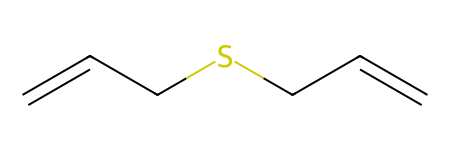

In [48]:
Test_SMILES = 'C=CCSCC=C'

mol = Chem.MolFromSmiles(Test_SMILES)
y = Chem.MolToSmiles(mol)
mol

In [19]:
# Set the figure size - handy for larger output
plt.rcParams["figure.figsize"] = [10, 6]

# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

<Axes: xlabel='odors'>

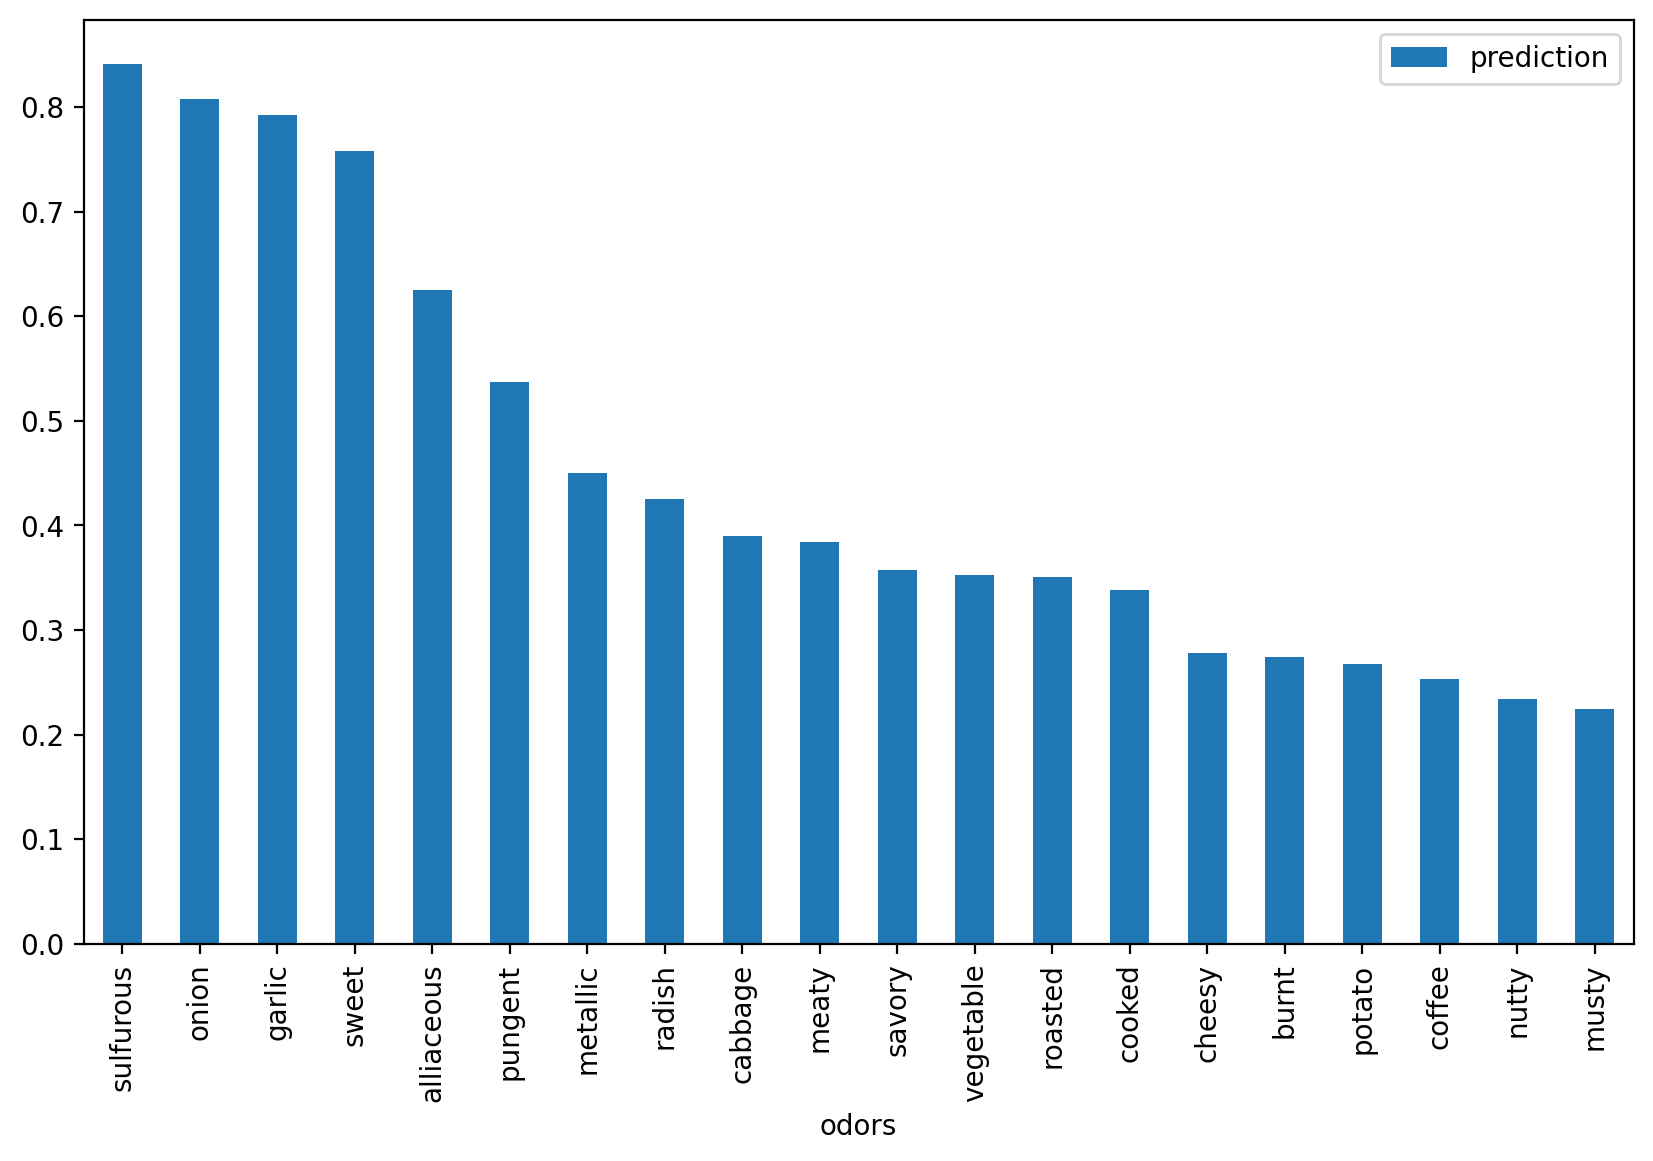

In [49]:
featurizer = GraphFeaturizer()
featurized_data = featurizer.featurize(Test_SMILES)

# Get predictions from trained model
prediction = model.predict(dc.data.NumpyDataset(featurized_data))

# Visualize the top 10 predictions
prediction_df = pd.DataFrame({'odors': TASKS, 'prediction': prediction.squeeze()}).sort_values(by='prediction', ascending=False)
prediction_df[:20].plot.bar(x='odors', y='prediction')

In [50]:
threshold = 0.5
inputs_labels = [(prediction > threshold).astype(int)[0]]

In [51]:
inputs = [[featurized_data[0]]]

In [52]:
inputs_weights = np.array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [53]:
""" 
Considering that the input of the model is a SMILES string, 
it is converted to DGLGraph using GraphFeaturizer() and _prepare_batch()
"""

g, labels, weights = model._prepare_batch((inputs, inputs_labels, inputs_weights))

In [54]:
g

Graph(num_nodes=7, num_edges=12,
      ndata_schemes={'x': Scheme(shape=(134,), dtype=torch.float32)}
      edata_schemes={'edge_attr': Scheme(shape=(6,), dtype=torch.float32)})

Target in Integrated Gradients Method:

When dealing with a non-scalar output, such as in classification models or multi-target regression scenarios, the gradients are computed for a specific element of the output. For classification models, this typically means calculating the gradient with respect to the output associated with the true class or the class predicted by the model, which is referred to as the target.

In [55]:
import numpy as np

# Find the index of the highest value
highest_index = np.argmax(prediction)

"""
The integrated gradients method typically requires specifying a target class for which the gradients are computed. 
In this context, the target class is chosen as the odor label with the highest predicted probability or odor label of interest. 
This approach helps to focus the explanation on the most relevant prediction made by the model.
"""

target = int(highest_index)

print("Index of the highest value:", highest_index)
print("Label:", TASKS[highest_index])

Index of the highest value: 121
Label: sulfurous


In [33]:
import torch
from functools import partial
from captum.attr import IntegratedGradients
from torch_geometric.utils import from_dgl, to_dgl

In [56]:
data = from_dgl(g)

In [34]:
torch.backends.cudnn.enabled=False

In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [57]:
# Edge explainability

def model_edge_forward(edge_mask, g):
    data = from_dgl(g)
    data.edge_attr = edge_mask
    new_g = to_dgl(data)
    out = model.model(new_g)
    return out[0]


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

edge_mask = data.edge_attr.requires_grad_(True).to(device)

ig = IntegratedGradients(partial(model_edge_forward, g=g))

ig_attr_edge = ig.attribute(edge_mask, target=target,
                            internal_batch_size=g.num_edges(), n_steps=3)

In [58]:
# Node explainability

def model_node_forward(node_mask,g):
    data = from_dgl(g)
    data.x = node_mask
    new_g = to_dgl(data)
    out = model.model(new_g)
    return out[0]

node_mask = data.x.requires_grad_(True).to(device)

ig = IntegratedGradients(partial(model_node_forward, g=g))

ig_attr_node = ig.attribute(node_mask, target=target,
                            internal_batch_size=g.num_nodes())

Output: 

The Integrated Gradients class attribute method returns input attributions with the same size and dimensionality as the inputs (nodes and edges). 

The attributions were aggregated  and rescaled to give a sing;e relative attribution value representing the importance of the graph nodes and edges.

Node Attributions

In [59]:
ig_attr_node = ig_attr_node.abs().sum(dim=1)

# Rescaling

ig_attr_node /= ig_attr_node.max()

ig_attr_node

tensor([0.0610, 0.1336, 0.1336, 0.0610, 0.3265, 1.0000, 0.3265],
       device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)

In [60]:
node_list = ig_attr_node.tolist()
node_list

[0.06097530428735916,
 0.13355852927670603,
 0.13355852809286423,
 0.06097530705061317,
 0.3264978440581468,
 1.0,
 0.326497846712926]

Edge Attribution

In [61]:
sum_tensor = ig_attr_edge.abs().sum(dim=1)

# Reshape the tensor into pairs; each pair representing a single bond (directed)
ig_attr_edge = sum_tensor.view(-1, 2)

# Sum the elements in each pair to get the value of a single bond
ig_attr_edge = torch.sum(ig_attr_edge, dim=1)

# Rescaling
ig_attr_edge /= ig_attr_edge.max()

ig_attr_edge

tensor([0.4791, 0.6062, 1.0000, 1.0000, 0.6062, 0.4791], device='cuda:0',
       dtype=torch.float64, grad_fn=<DivBackward0>)

In [62]:
edge_list = ig_attr_edge.tolist()
edge_list

[0.47910542787668575,
 0.6062098564115913,
 0.9999999790755246,
 1.0,
 0.6062096890157891,
 0.4791054209018606]

RDKIT Playground

In [43]:
from __future__ import print_function
from rdkit.Chem.Draw import rdMolDraw2D
import io
from PIL import Image
from collections import defaultdict
from rdkit.Chem import rdmolfiles
from rdkit.Chem import rdmolops
from collections import defaultdict
from rdkit.Chem.Draw import rdMolDraw2D

In [63]:
# To ensure the same order of the nodes and atoms is retained with RDkit and IG

order = rdmolfiles.CanonicalRankAtoms(mol)
mol = rdmolops.RenumberAtoms(mol, order)

In [64]:
colors = [(1.0, 0.1, 0.0), (0.3, 1.0, 0.0)]

athighlights = defaultdict(list)
arads = {}

bndhighlights = defaultdict(list)

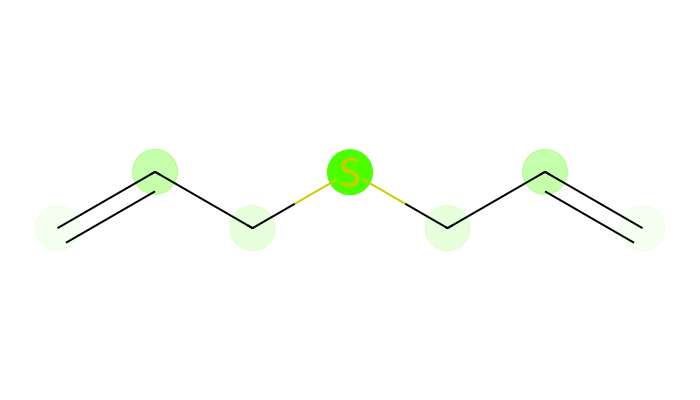

In [65]:
# Node Attribution Visualization

for i, a in enumerate(mol.GetAtoms()):
    aid = a.GetIdx()   
    if node_list[i] == 0:
        continue
    else:
        # Node attribution is visualized by the transparency. Proportional to the values in the node_list
        trans_atom = node_list[i]
        athighlights[aid].append((colors[1][0], colors[1][1], colors[1][2], trans_atom))

bndhighlights = defaultdict(list)


d2d = rdMolDraw2D.MolDraw2DCairo(700,400)
d2d.DrawMoleculeWithHighlights(mol,"",dict(athighlights),dict(bndhighlights),arads,{})
d2d.FinishDrawing()
bio = io.BytesIO(d2d.GetDrawingText())
Image.open(bio)

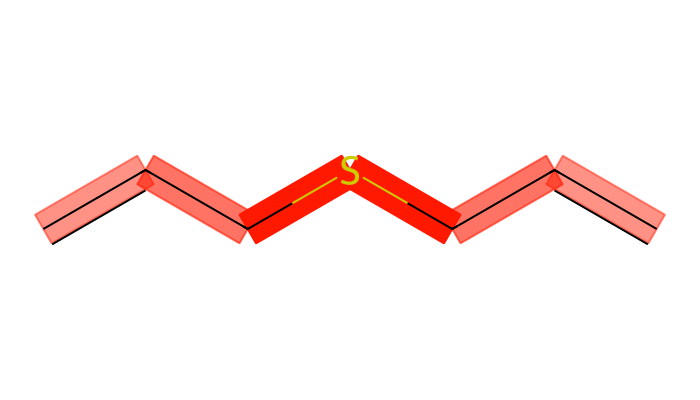

In [66]:
# Edge Attribution Visualization

athighlights = defaultdict(list)

for i, a in enumerate(mol.GetBonds()):
    aid1 = a.GetBeginAtomIdx()
    aid2 = a.GetEndAtomIdx()

    bid = mol.GetBondBetweenAtoms(aid1,aid2).GetIdx()
    # Edges attribution is visualized by the transparency. Proportional to the values in the edge_list
    trans_bnd = edge_list[i]
    bndhighlights[bid].append((colors[0][0], colors[0][1], colors[0][2], trans_bnd))


d2d = rdMolDraw2D.MolDraw2DCairo(700,400)
d2d.DrawMoleculeWithHighlights(mol,"",dict(athighlights),dict(bndhighlights),arads,{})
d2d.FinishDrawing()
bio = io.BytesIO(d2d.GetDrawingText())
Image.open(bio)